In [236]:
%matplotlib inline

# Task 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import  linear_model
import seaborn as sns
import math
np.set_printoptions(precision=3)
plt.rcParams.update({'font.size': 22})

In [237]:
path_X = "../Project1_data/X.csv"
X = pd.read_csv(path_X)
path_Y = "../Project1_data/Y.csv"
Y = pd.read_csv(path_Y)

merged = X.copy()
merged["DispFrames"] = Y["DispFrames"]
del merged["TimeStamp"]

def NMAE(gt,pred,test_size):
    psum = 0
    gt = np.array(gt)
    for i in range(0,test_size):
        psum+= abs(gt[i] - pred[i])
    tmp = psum / test_size
    return tmp / np.mean(gt)

[(0.68024446658088, 'runq-sz'), (0.09523045455039082, '%%memused'), (0.02338209394551447, 'proc/s'), (0.6083480409182177, 'cswch/s'), (0.3632869299443362, 'all_%%usr'), (0.57977260702422, 'ldavg-1'), (0.6556399804327232, 'totsck'), (0.00034177926994763945, 'pgfree/s'), (0.6633849383754925, 'plist-sz'), (0.5175597700808845, 'file-nr'), (0.014141658447472758, 'idel/s'), (0.0011566976823231278, 'tps')]
['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr', 'all_%%usr', '%%memused', 'proc/s', 'idel/s', 'tps', 'pgfree/s']
[(0.68024446658088, 'runq-sz'), (0.6633849383754925, 'plist-sz'), (0.6556399804327232, 'totsck'), (0.6083480409182177, 'cswch/s'), (0.57977260702422, 'ldavg-1'), (0.5175597700808845, 'file-nr'), (0.3632869299443362, 'all_%%usr'), (0.09523045455039082, '%%memused'), (0.02338209394551447, 'proc/s'), (0.014141658447472758, 'idel/s'), (0.0011566976823231278, 'tps'), (0.00034177926994763945, 'pgfree/s')]


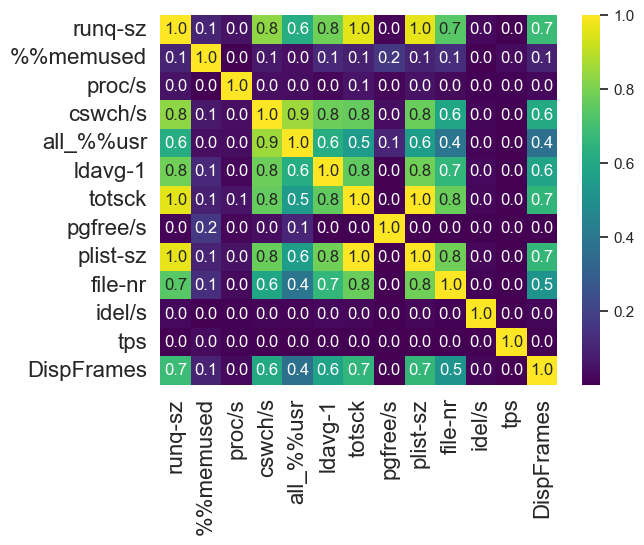

In [283]:
pcorr = np.corrcoef(merged,rowvar=0)
pcorr2 = np.square(pcorr)
corr = [(pow(pcorr[e][12],2),merged.columns[e]) for e in range(0,12)]
sns.set(font_scale=1.0)

print(corr)
#sns.heatmap(pcorr, annot=True, fmt=".1f",cmap="viridis")
sns.heatmap(pcorr2, annot=True, fmt=".1f",cmap="viridis")
plt.xticks(ticks=[x+0.5 for x in range(0,13)],labels=[fname for fname in merged.columns],rotation=90,fontsize="16")
plt.yticks(ticks=[x+0.5 for x in range(0,13)],labels=[fname for fname in merged.columns],rotation=0,fontsize="16")
plt.savefig("HeatMap2.pdf",bbox_inches='tight')

for i in range(0,12):
    for j in range(0,12):
        if corr[i][0] > corr[j][0]:
            tmp = corr[i]
            corr[i] = corr[j]
            corr[j] = tmp
#ll = corr[6]
#corr[6] = corr[0]
#corr[0] = ll
print([corr[e][1] for e in range(12) ])
print(corr)



In [284]:
tmp = X.copy()
del tmp["TimeStamp"]

tmp["DispFrames"] = Y["DispFrames"]
sample_size = 1080
T = tmp.sample(sample_size,replace=False)
tmp = tmp.drop(T.index)
test_labels = T.iloc[:,-1:]
test_features = T.iloc[:,:-1]

columns = tmp.columns[:-1]
column_combinations = []
for k in range(1,13):
    kk = []
    for q in range(0,12):
        if(q<k):
            kk.append(corr[q][1])
    column_combinations.append(kk)
print(column_combinations)

# Generate all possible sub-dataframes
all_subdataframes = []
for column_subset in column_combinations:
    cols = column_subset
    cols.append("DispFrames")
    sub_dataframe = tmp[list(cols)]
    all_subdataframes.append(sub_dataframe)

[['runq-sz'], ['runq-sz', 'plist-sz'], ['runq-sz', 'plist-sz', 'totsck'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr', 'all_%%usr'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr', 'all_%%usr', '%%memused'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr', 'all_%%usr', '%%memused', 'proc/s'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr', 'all_%%usr', '%%memused', 'proc/s', 'idel/s'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr', 'all_%%usr', '%%memused', 'proc/s', 'idel/s', 'tps'], ['runq-sz', 'plist-sz', 'totsck', 'cswch/s', 'ldavg-1', 'file-nr', 'all_%%usr', '%%memused', 'proc/s', 'idel/s', 'tps', 'pgfree/s']]


In [285]:
import time

start_time = time.time()

min_NMAE_h = 1
min_model_h = 0
min_feat_h = []

result_df_h = pd.DataFrame(columns=["features","NMAE"])
count = 0

row_list = []
for df in all_subdataframes:
    train_labels = df.iloc[:,-1:]
    train_features = df.iloc[:,:-1]
    col = train_features.columns
    sub_test_features = test_features[list(col)]
    regr = linear_model.LinearRegression()
    regr.fit(train_features,train_labels)
    pred = regr.predict(sub_test_features)
    nmae = NMAE(test_labels,pred,len(test_labels))
    row_list.append({"features":len(col),"NMAE":nmae[0]})
    if nmae < min_NMAE_h:
        min_NMAE_h = nmae
        min_model_h = regr
        min_feat_h = col
result_df_h = pd.DataFrame(row_list)



print("--- %s seconds ---" % (time.time() - start_time))

--- 0.13803601264953613 seconds ---


In [277]:
from itertools import combinations
columns = tmp.columns[:-1]

all_column_combinations = []
for r in range(1, len(columns) + 1):
    column_combinations = combinations(columns, r)
    all_column_combinations.extend(column_combinations)

# Generate all possible sub-dataframes
all_subdataframes = []
for column_subset in all_column_combinations:
    cols = list(column_subset)
    cols.append("DispFrames")
    sub_dataframe = tmp[list(cols)]
    all_subdataframes.append(sub_dataframe)

In [278]:
import time

start_time = time.time()

min_NMAE = 1
min_model = 0
min_feat = []

result_df = pd.DataFrame(columns=["features","NMAE"])
count = 0

row_list = []
for df in all_subdataframes:
    train_labels = df.iloc[:,-1:]
    train_features = df.iloc[:,:-1]
    col = train_features.columns
    sub_test_features = test_features[list(col)]
    regr = linear_model.LinearRegression()
    regr.fit(train_features,train_labels)
    pred = regr.predict(sub_test_features)
    nmae = NMAE(test_labels,pred,len(test_labels))
    row_list.append({"features":len(col),"NMAE":nmae[0]})
    if nmae < min_NMAE:
        min_NMAE = nmae
        min_model = regr
        min_feat = col
result_df = pd.DataFrame(row_list)



print("--- %s seconds ---" % (time.time() - start_time))

--- 31.038793087005615 seconds ---


In [134]:
print(result_df_h)
print(min_feat)
print(min_NMAE)

    features      NMAE
0          1  0.107982
1          2  0.108072
2          3  0.106626
3          4  0.106322
4          5  0.106291
5          6  0.106292
6          7  0.093425
7          8  0.093186
8          9  0.093234
9         10  0.093298
10        11  0.093315
11        12  0.093014
Index(['runq-sz', '%%memused', 'cswch/s', 'all_%%usr', 'pgfree/s', 'plist-sz',
       'file-nr'],
      dtype='object')
[0.093]


              NMAE
features          
1         0.102290
2         0.094344
3         0.086788
4         0.086650
5         0.086223
6         0.085688
7         0.085663
8         0.085663
9         0.085710
10        0.085843
11        0.085972
12        0.087064


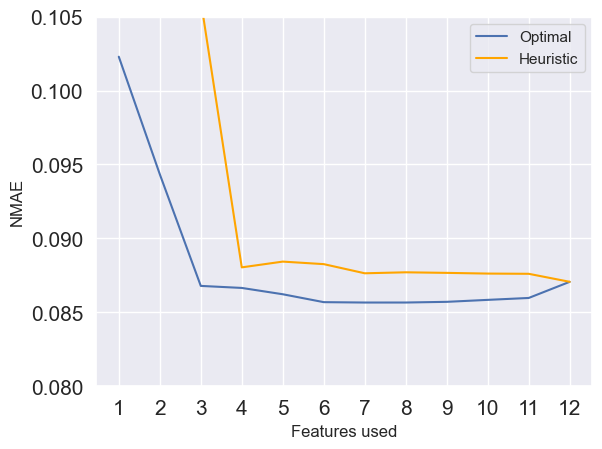

In [279]:
min_opt = result_df.groupby("features").min()
print(min_opt)
plt.plot(min_opt,label="Optimal")
plt.plot(result_df_h["features"],result_df_h["NMAE"],label="Heuristic",color="orange")
#plt.errorbar(mean_errors.index, mean_errors.values, yerr=std_dev.values, marker='o', linestyle='-', capsize=5, color='black', ecolor='black', label='Mean Error')
plt.xlabel('Features used')
plt.ylabel('NMAE')
plt.legend()
ticks=[i for i in range(1,13)]
plt.ylim(0.08,0.105)
plt.xticks(ticks=ticks,fontsize="15")
plt.yticks(ticks=[0.08+i*0.005 for i in range(0,6) ],fontsize="15")

#plt.fill_between(mean_errors.index, mean_errors.values-std_dev.values, mean_errors.values+std_dev.values,color="red")

plt.grid(True)
plt.savefig("Error_CPU.pdf",bbox_inches='tight')


In [295]:
from sklearn.decomposition import PCA

tmp = X.copy()
del tmp["TimeStamp"]

tmp["DispFrames"] = Y["DispFrames"]
sample_size = 1080
T = tmp.sample(sample_size,replace=False)
tmp = tmp.drop(T.index)
test_labels = T.iloc[:,-1:]
test_features = T.iloc[:,:-1]

row_list = []
times = []
for _ in range(0,20):
    tmp = X.copy()
    del tmp["TimeStamp"]
    
    tmp["DispFrames"] = Y["DispFrames"]
    sample_size = 1080
    T = tmp.sample(sample_size,replace=False)
    tmp = tmp.drop(T.index)
    test_labels = T.iloc[:,-1:]
    test_features = T.iloc[:,:-1]
    train_features = tmp.iloc[:,:-1]
    train_labels = tmp.iloc[:,-1:]

    for i in range(1,13):
        start_time = time.time()
        pca = PCA(n_components=i)
        pca_training_feat = pca.fit_transform(train_features.copy())
        pca_test_feat = pca.fit_transform(test_features.copy())
        regr = linear_model.LinearRegression()
        regr.fit(pca_training_feat,training_labels)
        pred = regr.predict(pca_test_feat)
        nmae = NMAE(test_labels,pred,len(test_labels))
        row_list.append({"features":i,"NMAE":nmae[0]})
        print("--- %s seconds ---" % (time.time() - start_time))
        times.append(time.time() - start_time)

pca_df = pd.DataFrame(row_list)
print(np.mean(times))



--- 0.06190323829650879 seconds ---
--- 0.0252377986907959 seconds ---
--- 0.023383140563964844 seconds ---
--- 0.0243222713470459 seconds ---
--- 0.024217844009399414 seconds ---
--- 0.024299144744873047 seconds ---
--- 0.0244748592376709 seconds ---
--- 0.0257418155670166 seconds ---
--- 0.02305769920349121 seconds ---
--- 0.021175861358642578 seconds ---
--- 0.0191800594329834 seconds ---
--- 0.016424179077148438 seconds ---
--- 0.025769948959350586 seconds ---
--- 0.023041725158691406 seconds ---
--- 0.02295398712158203 seconds ---
--- 0.02348804473876953 seconds ---
--- 0.02855992317199707 seconds ---
--- 0.024194002151489258 seconds ---
--- 0.027258872985839844 seconds ---
--- 0.029848098754882812 seconds ---
--- 0.025402307510375977 seconds ---
--- 0.016071081161499023 seconds ---
--- 0.01718306541442871 seconds ---
--- 0.016913890838623047 seconds ---
--- 0.02447223663330078 seconds ---
--- 0.023185014724731445 seconds ---
--- 0.025887012481689453 seconds ---
--- 0.024263858795

In [281]:
print(pca_df)

     features      NMAE
0           1  0.214051
1           2  0.120809
2           3  0.117548
3           4  0.121925
4           5  0.121522
..        ...       ...
235         8  0.136873
236         9  0.136412
237        10  0.137193
238        11  0.135888
239        12  0.137524

[240 rows x 2 columns]


              NMAE
features          
1         0.102290
2         0.094344
3         0.086788
4         0.086650
5         0.086223
6         0.085688
7         0.085663
8         0.085663
9         0.085710
10        0.085843
11        0.085972
12        0.087064


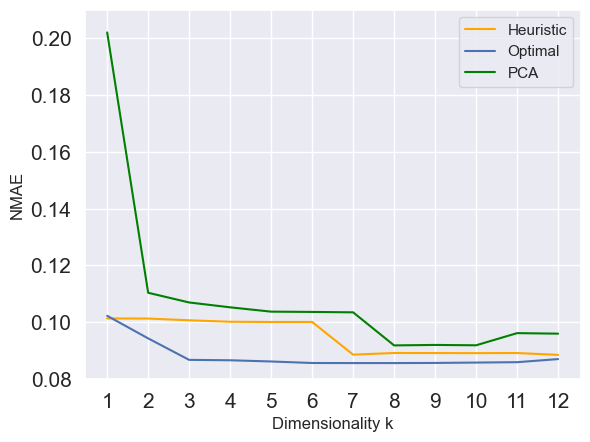

In [291]:
min_opt = result_df.groupby("features").min()
min_pca = pca_df.groupby("features").min()
print(min_opt)


plt.plot(result_df_h["features"],result_df_h["NMAE"],label="Heuristic",color="orange")
plt.plot(min_opt,label="Optimal")
plt.plot(min_pca,label="PCA",color="green")
#plt.errorbar(mean_errors.index, mean_errors.values, yerr=std_dev.values, marker='o', linestyle='-', capsize=5, color='black', ecolor='black', label='Mean Error')
plt.xlabel('Dimensionality k')
plt.ylabel('NMAE')
plt.legend()
ticks=[i for i in range(1,13)]
plt.ylim(0.08,0.21)
plt.yticks(fontsize="15")
plt.xticks(ticks=ticks,fontsize="15")
#plt.fill_between(mean_errors.index, mean_errors.values-std_dev.values, mean_errors.values+std_dev.values,color="red")

plt.grid(True)
plt.savefig("Error_PCA_C.pdf",bbox_inches='tight')